<a href="https://colab.research.google.com/github/niravshah241/deeponet_rough_surface/blob/main/Dirichlet/deeponet_surface_dirichlet_fnn_batch_normalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [2]:
# set wavenumber and wavelength
k = 2.0 * np.pi
lamb =  2.0 * np.pi / k

# domain [la,lb]
la = -12.0 * lamb
lb = 12.0 * lamb

# define the mesh for calculation
N_obs = 240
h_obs = (lb - la) / N_obs
mesh_obs = np.linspace(la, lb, (N_obs + 1))

mesh_mid_obs = np.zeros(N_obs + 1)

mesh_mid_obs[0] = la

for od in range(N_obs):
    mesh_mid_obs[od + 1] = (mesh_obs[od] + mesh_obs[od+1])/2.0

# transform numpy mesh to torch mesh
x_mid_obs = torch.tensor(mesh_mid_obs, dtype = torch.float32, requires_grad = True)
x_mesh_obs = torch.tensor(mesh_obs, dtype = torch.float32, requires_grad = True)

# mesh point input for the trunk network
x_tensor = x_mid_obs[1:]
x_tensors = x_tensor.detach()

# surface height range
hmax = 0.2 * lamb
hmin = -0.2 * lamb

In [3]:
# load data
path = "data_use_dirichlet/"
data1 = torch.load(path+'data1.pt')
data2 = torch.load(path+'data2.pt')
data3 = torch.load(path+'data3.pt')
data4 = torch.load(path+'data4.pt')
data5 = torch.load(path+'data5.pt')
data6 = torch.load(path+'data6.pt')
data7 = torch.load(path+'data7.pt')
data8 = torch.load(path+'data8.pt')
data9 = torch.load(path+'data9.pt')
data10 = torch.load(path+'data10.pt')
data11 = torch.load(path+'data11.pt')
data12 = torch.load(path+'data12.pt')
data13 = torch.load(path+'data13.pt')
data14 = torch.load(path+'data14.pt')
data15 = torch.load(path+'data15.pt')
data16 = torch.load(path+'data16.pt')
data17 = torch.load(path+'data17.pt')
data18 = torch.load(path+'data18.pt')
data19 = torch.load(path+'data19.pt')
data20 = torch.load(path+'data20.pt')

print(dir(data1))

data_train = data1 + data2 + data3 + data4 + data5 + data6 + data7 + data8 + data9 + data10 \
+ data11 + data12 + data13 +data14 + data15 + data16 + data17 + data18 + data19 + data20

size_data = len(data_train)
print('total number of data = ', size_data)

# put surface height, scattered data, and measurement height in arrays
hei_array = []
phis_array = []
zz_array = []

for i in range(size_data):
    hei_array.append(data_train[i][0])
    phis_array.append(data_train[i][1])
    zz_array.append(data_train[i][2])

# stack the data in one tensor
hei_tensors = torch.stack(hei_array).detach()
phis_tensors = torch.stack(phis_array).detach()
phis_real_tensors = torch.real(phis_tensors)
phis_imag_tensors = torch.imag(phis_tensors)
zz_tensors = torch.stack(zz_array).detach()


# note that the normalzation range is [-0.5,0.5]
def normalize_tensor(input_tensor):

    min_val = torch.min(input_tensor)
    max_val = torch.max(input_tensor)
    normalized_tensor = (input_tensor - min_val) / (max_val - min_val) - 0.5

    return normalized_tensor

# normalization of data
normalized_hei_tensors = normalize_tensor(hei_tensors)
normalized_phis_real_tensors = normalize_tensor(phis_real_tensors)
normalized_phis_imag_tensors = normalize_tensor(phis_imag_tensors)
normalized_x_tensors = normalize_tensor(x_tensors)
normalized_zz_tensors = normalize_tensor(zz_tensors)


# inverse normalization of data, used for plotting original surface height
def inverse_normalize_tensor(normalized_tensor, original_max, original_min):

    return (normalized_tensor + 0.5) * (original_max - original_min) + original_min

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
total number of data =  20000


In [4]:
# structure for a uniform feed-forward neural network

class FNN(nn.Module):

    # input_size: the size of input tensor
    # output_size: size of output tensor
    # hidden_layers: number of hidden layers
    # hidden_neurons: number of hidden neurons per hidden layer
    # activation: activation function

    def __init__(self, input_size, output_size, hidden_layers, hidden_neurons, activation):

        super(FNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.activation = activation

        self.input_layer = nn.Linear(input_size, hidden_neurons)
        self.hidden_layers_list = nn.ModuleList()
        self.batch_norm_layer = nn.ModuleList()
        for _ in range(hidden_layers - 1):
            self.hidden_layers_list.append(nn.Linear(hidden_neurons, hidden_neurons))
            self.batch_norm_layer.append(nn.BatchNorm1d(hidden_neurons))
        self.output_layer = nn.Linear(hidden_neurons, output_size)

    def forward(self, x):

        x = self.activation(self.input_layer(x))

        for i, hidden_layer in enumerate(self.hidden_layers_list):
            # x = self.activation(hidden_layer(x))
            x = self.activation(self.batch_norm_layer[i](hidden_layer(x)))

        x = self.activation(self.output_layer(x))

        return x

In [5]:
# main structure of DeepONet with multiple inputs (two inputs)

class DeepONet(nn.Module):

    # this deeponet contains 2 branch nets and 1 trunk net
    # input_size_branch1: size of input tensor for branch net1
    # hidden_layers_branch1: number of hidden layers in branch net1
    # hidden_neurons_branch1: number of neurons per hidden layer in branch net1
    # input_size_branch2: size of input tensor for branch net2
    # hidden_layers_branch2: number of hidden layers in branch net2
    # hidden_neurons_branch2: number of neurons per hidden layer in branch net2
    # hidden_layers_trunk: number of hidden layers in trunk net
    # hidden_neurons_trunk: number of neurons per hidden layer in trunk net
    # inner_layer_siz: size of the inner layer, i.e. value of p
    # activation: activation function
    # size_bias: size of the output bias tensor

    def __init__(self, input_size_branch1, hidden_layers_branch1, hidden_neurons_branch1, \
                 input_size_branch2, hidden_layers_branch2, hidden_neurons_branch2, \
                 hidden_layers_trunk, hidden_neurons_trunk, \
                 inner_layer_size, activation, size_bias):

        super(DeepONet, self).__init__()
        self.branch1 = FNN(input_size_branch1, inner_layer_size, hidden_layers_branch1, \
                           hidden_neurons_branch1, activation)
        self.branch2 = FNN(input_size_branch2, inner_layer_size, hidden_layers_branch2, \
                           hidden_neurons_branch2, activation)
        self.trunk = FNN(1, inner_layer_size, hidden_layers_trunk, hidden_neurons_trunk, activation)

        self.bias = nn.Parameter(torch.Tensor(1, size_bias))

    def forward(self, input_tensor_branch1, input_tensor_branch2, input_tensor_trunk):

        # input tensor for branch net1 is input_tensor_branch1
        # input tensor for branch net2 is input_tensor_branch2
        # input tensor for trunk net is input_tensor_trunk

        b_tensor = self.branch1(input_tensor_branch1)
        s_tensor = self.branch2(input_tensor_branch2)
        b = b_tensor * s_tensor

        input_tensor_trunk = input_tensor_trunk.view(-1, 1)
        t = self.trunk(input_tensor_trunk)

        output =  torch.matmul(b, t.T) + self.bias.squeeze()

        return output

In [6]:
# set up deeponet

# input of the branch net 1 is the measurement height Z
input_size_branch1 = 1
hidden_layers_branch1 = 3
hidden_neurons_branch1 = 32

# input of the branch net 2 is the real and imaginary parts of scattered data
input_size_branch2 = N_obs * 2
hidden_layers_branch2 = 4
hidden_neurons_branch2 = 64

# input of the trunk net
hidden_layers_trunk = 4
hidden_neurons_trunk = 64

# input layer size, value of p
inner_layer_size = 64

# activation function
activation = nn.Tanh()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('calculation device : ', device)


model = DeepONet(input_size_branch1, hidden_layers_branch1, hidden_neurons_branch1, \
                 input_size_branch2, hidden_layers_branch2, hidden_neurons_branch2, \
                 hidden_layers_trunk, hidden_neurons_trunk, \
                 inner_layer_size, activation, N_obs).to(device)

# count the number of hyperparameters in the neural network
def number_parameter_count(network):

    num_trainable_para = 0
    for param in network.parameters():
        if param.requires_grad == True:
            num_trainable_para += np.product(param.shape)

    return num_trainable_para

num_trainable_para = number_parameter_count(model)
print(f"Number of learnable model parameters: {num_trainable_para}")

calculation device :  cuda
Number of learnable model parameters: 69616


<ipython-input-6-9546e82ee3bd>:42: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  num_trainable_para = number_parameter_count(model)


In [7]:
# set the number of training data and testing data
size_training_data = 15000
size_testing_data = 5000

# set batch size
size_batch = 3000

# choose optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# number of epochs
num_epochs = 15000

time1 = time.time()

# main loop for the deeponet
model.train()
for epoch in range(num_epochs):

    total_loss = 0

    # loof for batches
    for i in range(0, size_training_data, size_batch):

        # data for the output
        hei_data_tensor = normalized_hei_tensors[i:i + size_batch].to(device)

        # branch net1 input: measurement height Z
        zz_input_tensor = normalized_zz_tensors[i:i + size_batch].to(device)

        # branch net2 input: real and imaginary parts of scattered data
        sc_real_tensor = normalized_phis_real_tensors[i:i + size_batch].to(device)
        sc_imag_tensor = normalized_phis_imag_tensors[i:i + size_batch].to(device)
        sc_input_tensor = torch.cat((sc_real_tensor, sc_imag_tensor), dim=1)

        # deeponet output
        hei_pred_tensor = model(zz_input_tensor, sc_input_tensor, normalized_x_tensors.to(device))

        # loss function
        loss = nn.MSELoss()(hei_pred_tensor, hei_data_tensor)

        # optimizing step with backward propagation
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}], Loss: {total_loss:.10f}')


time2 = time.time()
time_cost_minutes = (time2 - time1) / 60
print(f"Training time cost: {time_cost_minutes:.2f} minutes")

Epoch [100], Loss: 0.1176444069
Epoch [200], Loss: 0.0862500425
Epoch [300], Loss: 0.0718826288
Epoch [400], Loss: 0.0654368391
Epoch [500], Loss: 0.0582110193
Epoch [600], Loss: 0.0526722791
Epoch [700], Loss: 0.0446088379
Epoch [800], Loss: 0.0389856738
Epoch [900], Loss: 0.0358506665
Epoch [1000], Loss: 0.0335263731
Epoch [1100], Loss: 0.0306605031
Epoch [1200], Loss: 0.0278673763
Epoch [1300], Loss: 0.0256076767
Epoch [1400], Loss: 0.0242774445
Epoch [1500], Loss: 0.0230365996
Epoch [1600], Loss: 0.0221611131
Epoch [1700], Loss: 0.0204542447
Epoch [1800], Loss: 0.0187861626
Epoch [1900], Loss: 0.0177291881
Epoch [2000], Loss: 0.0166558386
Epoch [2100], Loss: 0.0154658353
Epoch [2200], Loss: 0.0149181206
Epoch [2300], Loss: 0.0143096417
Epoch [2400], Loss: 0.0140740681
Epoch [2500], Loss: 0.0133152162
Epoch [2600], Loss: 0.0133699551
Epoch [2700], Loss: 0.0129934256
Epoch [2800], Loss: 0.0119349337
Epoch [2900], Loss: 0.0113314195
Epoch [3000], Loss: 0.0111410113
Epoch [3100], Loss:

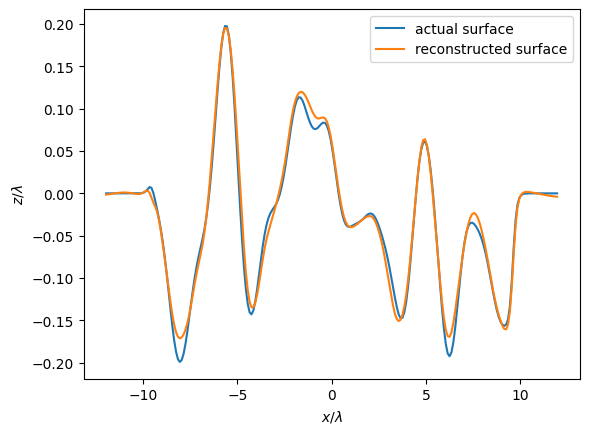

In [8]:
# test results using testing data
model.eval()
ntest = 17825

# original surface height
hei_actual_tensor = normalized_hei_tensors[ntest]
hei_actual = inverse_normalize_tensor(hei_actual_tensor, hmax, hmin)
hei_actual_vec = hei_actual.cpu().detach().numpy()

# input datas
zz_tensor_test = normalized_zz_tensors[ntest].to(device).unsqueeze(0)
sc_real_tensor_test = normalized_phis_real_tensors[ntest].to(device).unsqueeze(0)
sc_imag_tensor_test = normalized_phis_imag_tensors[ntest].to(device).unsqueeze(0)
# sc_input_tensor_test = torch.cat((sc_real_tensor_test, sc_imag_tensor_test), dim=0)
sc_input_tensor_test = torch.cat((sc_real_tensor_test, sc_imag_tensor_test), dim=1)

# output data (predicted surface)
hei_pred_tensor_test = model(zz_tensor_test, sc_input_tensor_test, normalized_x_tensors.to(device))
hei_pred = inverse_normalize_tensor(hei_pred_tensor_test, hmax, hmin)
hei_pred_vec = (hei_pred.cpu().detach().numpy()).squeeze(0)

line1, = plt.plot(mesh_mid_obs[1:] / lamb, hei_actual_vec / lamb)
line2, = plt.plot(mesh_mid_obs[1:] / lamb, hei_pred_vec / lamb)
plt.xlabel(r'$x/{\lambda}$')
plt.ylabel(r'$z/{\lambda}$')
leg=plt.legend([line1, line2],
        ['actual surface',
        'reconstructed surface'], loc = "best")
plt.show()

In [9]:
# calculate the l2 norm error
error_vec = hei_actual_vec - hei_pred_vec
print("l2 norm error is: ", np.linalg.norm(error_vec) / np.linalg.norm(hei_actual_vec))

l2 norm error is:  0.10860888


In [10]:
# save the hyperparameters
torch.save(model.state_dict(), 'model_parameters_dirichlet.pth')

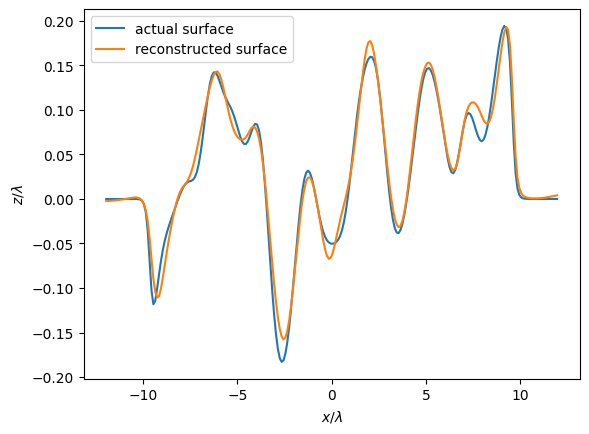

In [11]:
# test the method with noisy data

ntest = 19720

# original surface height
hei_actual_tensor = normalized_hei_tensors[ntest]
hei_actual = inverse_normalize_tensor(hei_actual_tensor, hmax, hmin)
hei_actual_vec = hei_actual.cpu().detach().numpy()

# input datas
zz_tensor_test = (normalized_zz_tensors[ntest].to(device)).unsqueeze(0)
sc_real_tensor_test = (normalized_phis_real_tensors[ntest].to(device)).unsqueeze(0)
sc_imag_tensor_test = (normalized_phis_imag_tensors[ntest].to(device)).unsqueeze(0)

# add white noise to the scattered data
# noise level eps
eps = 0.04
# random numbers in [-1,1]
random_float = (torch.rand_like(sc_real_tensor_test) - 0.5) * 2
sc_real_tensor_noise = sc_real_tensor_test * (1 + eps * random_float)
sc_imag_tensor_noise = sc_imag_tensor_test * (1 + eps * random_float)
# sc_input_tensor_noise = torch.cat((sc_real_tensor_noise, sc_imag_tensor_noise), dim=0)
sc_input_tensor_noise = torch.cat((sc_real_tensor_noise, sc_imag_tensor_noise), dim=1)

# output data (predicted surface)
hei_pred_tensor_noise = (model(zz_tensor_test, sc_input_tensor_noise, normalized_x_tensors.to(device))).squeeze(0)
hei_pred_noise = inverse_normalize_tensor(hei_pred_tensor_noise, hmax, hmin)
hei_pred_vec = hei_pred_noise.cpu().detach().numpy()

line1, = plt.plot(mesh_mid_obs[1:] / lamb, hei_actual_vec / lamb)
line2, = plt.plot(mesh_mid_obs[1:] / lamb, hei_pred_vec / lamb)
plt.xlabel(r'$x/{\lambda}$')
plt.ylabel(r'$z/{\lambda}$')
leg=plt.legend([line1, line2],
        ['actual surface',
        'reconstructed surface'], loc = "best")
plt.show()

In [12]:
# calculate the l2 norm error
error_vec = hei_actual_vec - hei_pred_vec
print("l2 norm error is: ", np.linalg.norm(error_vec) / np.linalg.norm(hei_actual_vec))

l2 norm error is:  0.15241484
